In [35]:
import polars as pl
from pathlib import Path
import jax.numpy as jnp
import numpy as np
from numpy.random import normal 
from jax import grad, hessian, jit, vmap, config
import jax
from functools import partial
from numpy import linalg
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from IPython.display import display
config.update("jax_enable_x64", True)
# config.update("jax_debug_nans", True)

In [36]:
exp_path = Path('data/2019/blg-0181')
data_path = exp_path / 'phot.dat'
params_path = exp_path / 'params.dat'
new_params = exp_path / 'clean_params.csv'
with params_path.open() as f:
    x = map(lambda x: ','.join(x.strip().split()),f.read().splitlines()[8:])
    res = '\n'.join(list(x))
    with new_params.open(mode='+w'):
        new_params.write_text(res)

params_schema = ['param','value', 'err']
params = pl.read_csv(new_params, has_header=False,new_columns=params_schema)
print(params)

shape: (8, 3)
┌───────┬──────────┬───────┐
│ param ┆ value    ┆ err   │
│ ---   ┆ ---      ┆ ---   │
│ str   ┆ f64      ┆ f64   │
╞═══════╪══════════╪═══════╡
│ Tmax  ┆ 2.4586e6 ┆ 0.073 │
│ tau   ┆ 30.003   ┆ 0.28  │
│ umin  ┆ 0.249    ┆ 0.001 │
│ Amax  ┆ 4.113    ┆ 0.023 │
│ Dmag  ┆ 1.536    ┆ 0.0   │
│ fbl   ┆ 1.0      ┆ 0.0   │
│ I_bl  ┆ 19.72    ┆ 0.002 │
│ I0    ┆ 19.72    ┆ 0.002 │
└───────┴──────────┴───────┘


In [37]:
ogle_Tmax = params.filter(param='Tmax').select(['value','err']).row(0)
ogle_tau = params.filter(param='tau').select(['value','err']).row(0)
ogle_umin = params.filter(param='umin').select(['value','err']).row(0)
ogle_I0 = params.filter(param='I0').select(['value','err']).row(0)
ogle_fbl = params.filter(param='fbl').select(['value','err']).row(0)
amplitude_const = 2.512

In [38]:
phot_schema = ['HJD', 'm', 'dm', 'seeing_estimation', 'sky_level']
data = pl.read_csv(data_path, has_header=False, new_columns=phot_schema, separator=' ')
GLE_BOUNDS_LINEAR = [ogle_Tmax[0]- 4,ogle_Tmax[0]+ 4]
num_simulations_nonlinear = 1000


In [39]:
print(data.select(pl.col('HJD').min()).item())


m_star, dm_star = data.filter((pl.col('HJD') < ogle_Tmax[0] - 3*ogle_tau[0]) #| ((pl.col('HJD') < GLE_BOUNDS[1] + 100))
                              
                              ).select(
    [
    ((pl.col('m')/pl.col('dm').pow(2)).sum()/(1/pl.col('dm').pow(2)).sum()).alias('m_star'),
    (1/(1/pl.col('dm').pow(2)).sum()).sqrt().alias('dm_star')
    ]).row(0)
print('m star',m_star,'+-', dm_star)
print('sigma', (ogle_I0[0] - m_star)/np.sqrt(dm_star**2 + ogle_I0[1]**2))
more_data = data.with_columns(
    [
        pl.lit(m_star).alias('m_star'),
        pl.lit(dm_star).alias('dm_star'),
     
     ])
more_data.plot.scatter(x='HJD', y=['m', 'm_star'])

2457424.87541
m star 19.718036029264397 +- 0.0020321886542267104
sigma 0.688803474403078


:NdOverlay   [Variable]
   :Scatter   [HJD]   (value)

In [40]:
intensity = more_data.with_columns([
    ((pl.col('m_star') - pl.col('m'))/amplitude_const * pl.lit(10).log()).exp().alias('I_rel')
])

intensity = intensity.with_columns(
    (pl.col('I_rel')/2.5 * pl.lit(10).log()* (pl.col('dm').pow(2)+ pl.col('dm_star').pow(2)).sqrt()).alias('dI_rel')
)
intensity
intensity.plot.scatter(x='HJD', y='I_rel')

:Scatter   [HJD]   (I_rel)

In [41]:
bounded_for_linear = intensity.filter(pl.col('HJD').is_between(*GLE_BOUNDS_LINEAR))
min_val_linear = bounded_for_linear.select(pl.col('HJD').min()).to_numpy().squeeze(1)[0]
GLE_linear = bounded_for_linear.with_columns(
    pl.col('HJD') - pl.col('HJD').min()

).select(
    [
    'HJD',
     'I_rel',
     'dI_rel'])
x_linear = GLE_linear.select(['HJD']).to_numpy().squeeze(1)
y_linear = GLE_linear.select(['I_rel']).to_numpy().squeeze(1)
dy_linear = GLE_linear.select(['dI_rel']).to_numpy().squeeze(1)
print(ogle_Tmax[0] - min_val_linear)
GLE_linear.plot.scatter(x='HJD', y='I_rel')


3.799529999960214


:Scatter   [HJD]   (I_rel)

In [42]:
def linear_fit(x: np.ndarray,y:np.ndarray,dy:np.ndarray,deg=2):
    x = np.matrix([np.power(x, index) for index in range(deg+1)]).T
    y = np.matrix(y).T

    V = np.matrix(np.diagflat(dy*dy))
    V_inv = linalg.inv(np.matrix(np.diagflat(dy*dy)))

    cov_estimator = np.matrix(linalg.inv(x.T * V_inv * x))
    estimator = cov_estimator * x.T * V_inv * y
    destimator = np.sqrt(cov_estimator.diagonal())
    chi_squared = ((y - x*estimator).T * V_inv * (y - x*estimator)).item(0)
    
    num_measure, num_params = x.shape
    return estimator.T.A1, destimator.A1, chi_squared, chi_squared/(num_measure - num_params), cov_estimator,


In [43]:
est, dest, *_ = linear_fit(x_linear,y_linear,dy_linear,deg=2)

In [44]:
def poly(B,x):
    return np.sum([p*np.power(x, index) for index, p in enumerate(B)], axis=0)

In [45]:
def plot_poly_fit(x, y, dy, title,deg=2, show_plot=True):
    est, dest,chi, chi_red, *_ = linear_fit(x,y,dy,deg=deg)
    if show_plot:
        fig, (ax0,ax1) = plt.subplots(nrows=2, sharex=True)
        #ax0.plot(data[:,0], data[:,1])
        ax0.set_ylabel(r'$\frac{I}{I_*}$')
        ax0.set_xlabel(r'translated HJD[days]')
        ax0.errorbar(x, y, yerr=dy, marker='.', linestyle='none', label='data', color='blue')
        
        ax0.plot(np.linspace(min(x), max(x),100), poly(est,np.linspace(min(x), max(x),100)), label='fit', color='orange')
        ax0.set_title(title)
        ax0.legend()
        ax1.errorbar(x, y - poly(est, x), yerr=dy, marker='.', linestyle='none', label='data', color='blue')
        ax1.plot(x, x - x, color='red')
        ax1.set_ylabel(r'$\frac{I}{I_*} - fit$')
        ax1.set_xlabel(r'translated HJD[days]')
        ax1.set_title('residual plot')
        plt.subplots_adjust(hspace=0.4)
        plt.show()
    return  est, dest,chi,chi_red

def calculate_params(est, dest, T_offset = GLE_BOUNDS_LINEAR[0]):
    T_0 = -est[1]/(2*est[2])
    dT_0 = T_0 * np.sqrt(np.power(dest[1]/est[1],2) + np.power(dest[2]/est[2],2))
    f_max = est[0] - np.power(est[1],2)/(4*est[2])
    df_max = np.sqrt(
        np.power(dest[0],2) +\
        np.power(est[1]*dest[1]/(2*est[2]),2) + \
        np.power(np.power(est[1],2)*dest[2]/(4*np.power(est[2],2)),2)
    )
    #print('fmax',f_max,'+-', df_max)
    u_min = np.sqrt(2*f_max/np.sqrt(np.power(f_max, 2) - 1) - 2)
    du_min = df_max * np.abs(((2/np.sqrt(np.power(f_max,2) - 1)) - 2*f_max**2 / np.power(f_max**2 - 1,3/2))/(2*u_min))
    
    tau = np.sqrt(-4/(est[2]*np.power(u_min,3) * np.power(np.power(u_min,2)+4,3/2)))
    dtau =  tau * np.sqrt((dest[2]/(2*est[2]))**2 +\
                             (-3/2 * du_min/u_min - 3/2 * u_min * du_min /(u_min**2 +4))**2
                             )
    #print('T0',T_offset + T_0, '+-', dT_0)
    #print('umin',u_min, '+-', du_min)
    #print('tau', tau, '+-', dtau)
    
    return  np.array([T_offset + T_0, u_min, tau]), np.array([dT_0, du_min, dtau])

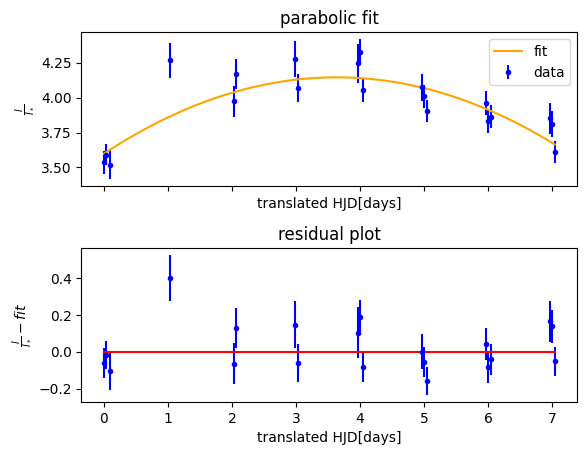

T0 2458554.2558791884 +- 0.5327279297860044
umin 0.24671428108468166 +- 0.008374564495055536
tau 28.0347660012041 +- 2.0634144207771143
[ 3.598926    0.30082667 -0.04141474] [0.04736875 0.03086886 0.00434081]
[ 1.31619127 10.26134426 10.48132531]
chi_red 1.8921198025051884
[2.16683414e-05 3.39443848e+00 7.36019848e+00]
sigma T 0.6846131853021691
sigma u 0.2710105832119576
sigma tau 0.945209619355524


In [46]:
est, dest, chi, chi_red = plot_poly_fit(x_linear,y_linear,dy_linear,'parabolic fit',deg=2)
params, dparams = calculate_params(est,dest)
par = params
par_errs = dparams
print('T0',params[0], '+-', dparams[0])
print('umin',params[1], '+-', dparams[1])
print('tau', params[2], '+-', dparams[2])
print(est, dest)
print(np.abs(dest/est *100))
print('chi_red', chi_red)
print(np.abs(dparams/params *100))

print('sigma T',(ogle_Tmax[0] - params[0])/np.sqrt(dparams[0]**2 + ogle_Tmax[1]**2))
print('sigma u',(ogle_umin[0] - params[1])/np.sqrt(dparams[1]**2 + ogle_umin[1]**2))
print('sigma tau',(ogle_tau[0] - params[2])/np.sqrt(dparams[2]**2 + ogle_tau[1]**2))


In [47]:
T0s = []
u_mins = []
taus = []
for i in range(10000):
    sampled = GLE_linear.sample(n=len(GLE_linear),with_replacement=True, seed=i).sort(by='HJD')
    x_linear = sampled.select(['HJD']).to_numpy().squeeze(1)
    y_linear = sampled.select(['I_rel']).to_numpy().squeeze(1)
    dy_linear = sampled.select(['dI_rel']).to_numpy().squeeze(1)
    #display(sampled.plot.scatter(x='HJD', y='I_rel'))
    est, dest, *_ = plot_poly_fit(x_linear,y_linear,dy_linear,'poly fit',deg=2,show_plot=False)
    if est[2] > 0:
        continue
    params, dparams = calculate_params(est,dest)
    T0s.append(params[0])
    u_mins.append(params[1])
    taus.append(params[2])
T0_series = pl.Series(r'$T_0$',T0s)
u_series = pl.Series(r'$u_{min}$',u_mins)
tau_series = pl.Series(r'$\tau$',taus)

In [48]:
display(T0_series.plot.hist(bins=200,bin_range=GLE_BOUNDS_LINEAR))
print('T_0',T0_series.mean(),'+-', T0_series.std())
display(u_series.plot.hist(bins=200, bin_range=[0.2,0.3]))
print('u min',u_series.mean(),'+-', u_series.std())
display(tau_series.plot.hist(bins=200,bin_range=[20,50]))
print('tau',tau_series.mean(),'+-', tau_series.std())

:Histogram   [$T_0$]   (Count)

T_0 2458554.1662136046 +- 0.7377001410219848


:Histogram   [$u_{min}$]   (Count)

u min 0.2463451965203024 +- 0.0029983532421085394


:Histogram   [$\tau$]   (Count)

tau 28.827939794010792 +- 5.764105069819901


In [49]:
print('closeness T0', jnp.abs(par[0] - T0_series.mean())/par_errs[0])
print('closeness u min', jnp.abs(par[1] - u_series.mean())/par_errs[1])
print('closeness tau', jnp.abs(par[2] - tau_series.mean())/par_errs[2])

closeness T0 0.16831402820674887
closeness u min 0.044072090506577406
closeness tau 0.3843986863811726


T_0 2458554.1662136046 +- 0.7377001410219848
[2458553.624, 2458555.124]


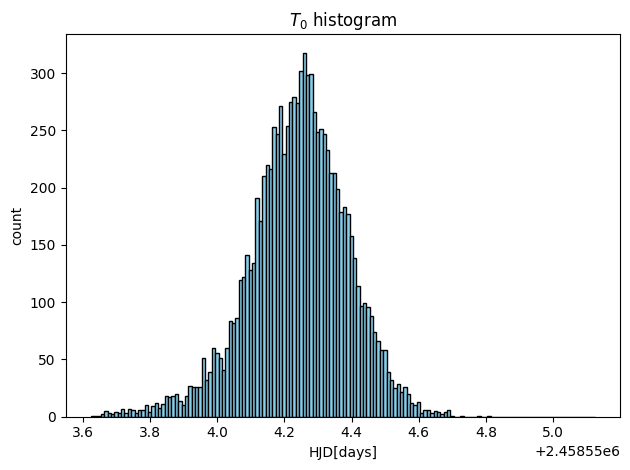

In [50]:
fig,  axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
axs.hist(T0s,bins=150,range=[GLE_BOUNDS_LINEAR[0]+3, GLE_BOUNDS_LINEAR[1] - 3.5],color='skyblue', edgecolor='black')
axs.set_title('$T_0$ histogram')
axs.set_ylabel('count')
axs.set_xlabel('HJD[days]')
print('T_0',T0_series.mean(),'+-', T0_series.std())
print([GLE_BOUNDS_LINEAR[0]+3, GLE_BOUNDS_LINEAR[1] - 3.5])

u_min 0.2463451965203024 +- 0.0029983532421085394


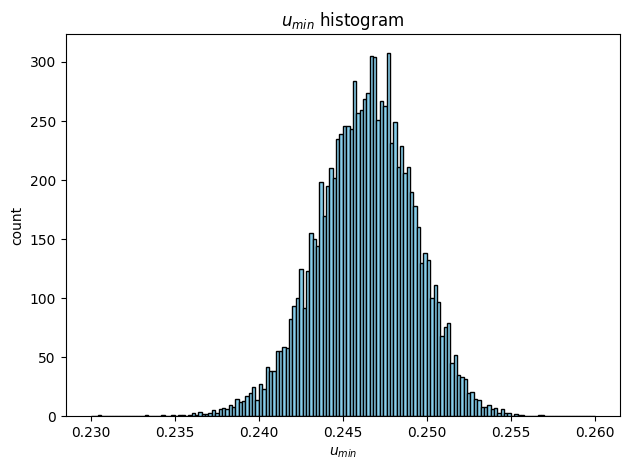

In [51]:
fig,  axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
axs.hist(u_series,bins=150,range=[0.23,0.26],color='skyblue', edgecolor='black')
axs.set_title(r'$u_{min}$ histogram')
axs.set_ylabel('count')
axs.set_xlabel(r'$u_{min}$')
print('u_min',u_series.mean(),'+-', u_series.std())

tau 28.827939794010792 +- 5.764105069819901


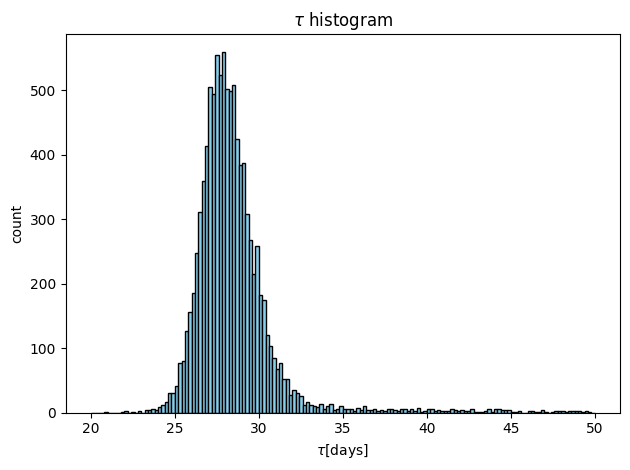

In [52]:
fig,  axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
axs.hist(tau_series,bins=150,range=[20,50],color='skyblue', edgecolor='black')
axs.set_title(r'$\tau$ histogram')
axs.set_ylabel('count')
axs.set_xlabel(r'$\tau$[days]')
print('tau',tau_series.mean(),'+-', tau_series.std())

# Non-linear fit 2D

In [53]:
bounded = intensity#.filter(pl.col('HJD').is_between(*GLE_BOUNDS))
min_val = bounded.select(pl.col('HJD').min()).to_numpy().squeeze(1)[0]
GLE = bounded.with_columns(
    pl.col('HJD') - pl.col('HJD').min()
).select(
    [
    'HJD',
     'I_rel',
     'dI_rel'])

x = GLE.select(['HJD']).to_numpy().squeeze(1)
y = GLE.select(['I_rel']).to_numpy().squeeze(1)
dy = GLE.select(['dI_rel']).to_numpy().squeeze(1)

GLE.plot.scatter(x='HJD', y='I_rel')


:Scatter   [HJD]   (I_rel)

In [54]:
@jit
def model(B,x):
    u = jnp.sqrt(B[1]**2+((x-B[0])/par[2])**2)
    mag = (u**2+2)/(u*jnp.sqrt(u**2+4))
    return mag

@partial(jit, static_argnums=(1,))
def chi_squared(params, model,x,y,dy):
    return jnp.sum(jnp.power((y - model(params, x))/dy,2))



In [55]:
print(ogle_Tmax[0] - min_val)
def clip_grad_norm(grad, max_norm):
    norm = jnp.linalg.norm(jax.tree_util.tree_leaves(jax.tree_map(jnp.linalg.norm, grad)))
    clip = lambda x: jnp.where(norm < max_norm, x, x * max_norm / (norm + 1e-6))
    return jax.tree_util.tree_map(clip, grad)

def grad_desc(x,y,dy,model,guess,loss=chi_squared, epsilon = 0.0000001, learning_rate = 0.1,max_iterations = 10000, constraints = None):
    B = np.array(guess)
    # chi_grad = jit(grad(chi_squared, argnums=0), static_argnums=(1,))
    chi_grad = jit(grad(loss, argnums=0), static_argnums=(1,))
    chi_hessian = jit(hessian(loss, argnums=0), static_argnums=(1,))
    chi = loss(B,model,x,y,dy)
    chi_grad_val =chi_grad(B,model,x,y,dy)
    chi_inv_hessian_val = jnp.linalg.pinv(chi_hessian(B,model,x,y,dy))
    norm = jnp.linalg.norm(chi_grad_val)
    i = 0
    while True:
        # if norm > clip:
        #     chi_grad_val = clip * chi_grad_val/norm

        delta_B = - learning_rate * jnp.linalg.matmul(chi_inv_hessian_val, chi_grad_val)
        #print(delta_B)
        B = B  + delta_B 
        chi = loss(B,model,x,y,dy)
        chi_grad_val =chi_grad(B,model,x,y,dy)
        chi_inv_hessian_val = jnp.linalg.pinv(chi_hessian(B,model,x,y,dy))
        norm = jnp.linalg.norm(delta_B)
        if  (norm < epsilon) or (i >= max_iterations):
            cov_mat =  jnp.linalg.pinv(chi_hessian(B,model,x,y,dy)/2)
            errors = np.sqrt(np.diag(cov_mat))
            return B, errors, chi, chi/(x.shape[0] - B.shape[0]), cov_mat
        if i % 1000 == 0:
            pass
            # print(B)
            # print(norm)
        i+=1

#B, errors, chi, chi_red, cov = grad_desc(x,y,dy,model=model,guess=[params[0] - min_val, params[1]])


1129.7485899999738


In [56]:
# print(B, errors)
# print(chi_squared(B,model,x,y,dy))
#print(chi_squared(B+ np.array([0,errors[1]]),model,x,y,dy))

def plotChi2(B, errors, chi_squared, model,x,y,dy, i=0,j=1, xlabel=None, ylabel=None, ax:Axes | None = None, clabel=True, chi_spacing = 1, title=''):
    
    if not ax:
        fig, ax = plt.subplots(nrows=1)
        ax.set_title(title)
    num = 200
    xi = jnp.linspace(B[i]-3*errors[i], B[i]+3*errors[i], num)
    xj =  jnp.linspace(B[j]-3*errors[j], B[j]+3*errors[j], num)
    def it(B):
        for idx,elem in enumerate(B):
            if (idx == i) or (idx ==j):
                yield jnp.linspace(elem-3*errors[idx], elem+3*errors[idx], num)
            else:
                yield elem.reshape(1,)
    axis = B.shape[0]#2 if B.shape[0] == 2 else 3
    Bs = jnp.stack(jnp.meshgrid(*it(B)), axis=axis).squeeze()
    Z = vmap(vmap(chi_squared,(0,None,None,None,None),0), (0,None,None,None,None),0)(Bs,model,x,y,dy)
    Z = jnp.transpose(Z)
    chi_min = jnp.min(Z)
    chi_max = jnp.max(Z)
    levels = np.arange(chi_min, chi_max, chi_spacing)

    
    h = ax.contour(xi, xj, Z, levels = levels)
    ax.errorbar(B[i], B[j], xerr=errors[i], yerr=errors[j])
    
    if clabel:
        ax.clabel(h, colors='b',fmt='%2.1f', fontsize=11,inline=True, levels=levels[:8])
    if xlabel:
        ax.set_xlabel(xlabel)
    
    if ylabel:
        ax.set_ylabel(ylabel)
    # return ax.imshow()
    #[txt.set_backgroundcolor('white') for txt in q]
    #plt.show()

#plotChi2(B, errors, chi_squared, model,x,y,dy,i=0,j=2)
#plotChi2(B, errors, chi_squared, model,x,y,dy,i=1,j=2)



In [57]:
def plot_fit(x, y, dy, title,model, params, show_plot=True):
    #est, dest, chi, chi_red, cov = grad_desc(x,y,dy,model,guess=guess, epsilon = 0.0001)#(x,y,dy,deg=deg)
    if show_plot:
        fig, (ax0,ax1) = plt.subplots(nrows=2, sharex=True)
        #ax0.plot(data[:,0], data[:,1])
        ax0.set_ylabel(r'$\frac{I}{I_*}$')
        ax0.set_xlabel(r'translated HJD[days]')
        ax0.errorbar(x, y, yerr=dy ,marker='.', linestyle='none', label='data', color='blue')
        
        ax0.plot(np.linspace(min(x), max(x),1000), model(params, np.linspace(min(x), max(x),1000)), label='fit', color='orange')
        ax0.set_title(title)
        ax0.legend()
        ax1.errorbar(x, y - model(params, x), yerr=dy, marker='.', linestyle='none', label='data', color='blue')
        ax1.plot(x, x - x, color='red')
        ax1.set_ylabel(r'$\frac{I}{I_*} - fit$')
        ax1.set_xlabel(r'translated HJD[days]')
        ax1.set_title('residual plot')
        plt.subplots_adjust(hspace=0.4)
        plt.show()
    return  None

In [58]:
def N_sigma(pred, target):
    return np.abs((pred[0] - target[0])/np.sqrt(pred[1]**2+target[1]**2))

7238.056716380826 2.2443586717459927
[1.12981840e+03 2.47597457e-01]
[0.06760089 0.00130648]
T_0 2458554.6938059097 +- 0.06760088865852713
u_min 0.24759745727626437 +- 0.0013064842064711341
T n sigma 0.701615474813088
u n sigma 0.8524715906081807


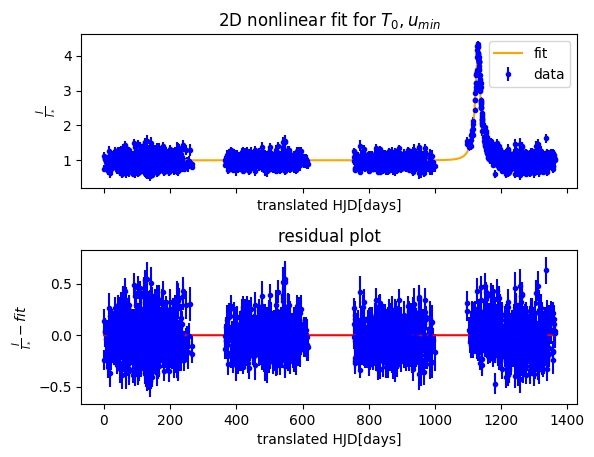

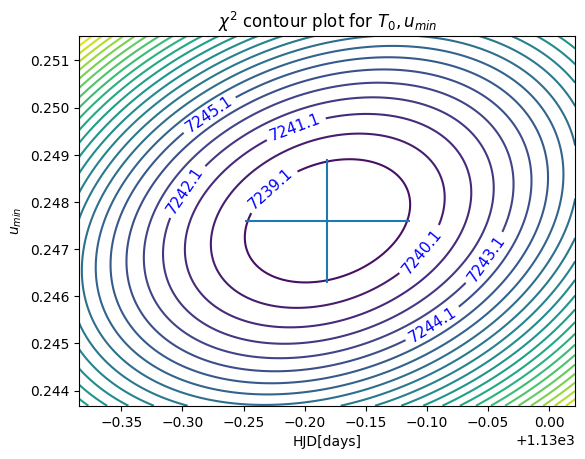

In [59]:
B, errors, chi, chi_red, cov = grad_desc(x,y,dy,model=model,guess=[par[0] - min_val,par[1]])
D2_fit = B
D2_err = errors
print(chi, chi_red)
print(B)
print(errors)
print('T_0', B[0]+min_val,'+-', errors[0])
print('u_min', B[1],'+-', errors[1])
print('T n sigma', N_sigma((B[0]+min_val,errors[0]),ogle_Tmax))
print('u n sigma', N_sigma((B[1],errors[1]),ogle_umin))

plot_fit(x,y,dy,title=r'2D nonlinear fit for $T_0, u_{min}$',model=model, params=B)

# fig, ax = plt.subplots(nrows=1)
plotChi2(B, errors, chi_squared, model,x,y,dy,i=0,j=1,xlabel='HJD[days]', ylabel=r'$u_{min}$', title=r'$\chi^2$ contour plot for $T_0, u_{min}$')


In [60]:
T0s = []
u_mins = []
taus = []
for i in range(num_simulations_nonlinear):
    if i % 100 == 0:
        print(i)
    sampled = GLE.sample(n=len(GLE),with_replacement=True, seed=i).sort(by='HJD')
    x_sample = sampled.select(['HJD']).to_numpy().squeeze(1)
    y_sample = sampled.select(['I_rel']).to_numpy().squeeze(1)
    dy_sample = sampled.select(['dI_rel']).to_numpy().squeeze(1)
    #display(sampled.plot.scatter(x='HJD', y='I_rel'))
    est, dest,chi,chi_red, cov= grad_desc(x_sample,y_sample,dy_sample,model=model,guess=[par[0] - min_val, par[1]])

    #params, dparams = calculate_params(est,dest)
    T0s.append(est[0]+min_val)
    u_mins.append(est[1])
T0_series = pl.Series(r'$T_0$',T0s)
u_series = pl.Series(r'$u_{min}$',u_mins)

0
100
200
300
400
500
600
700
800
900


In [61]:
print('T_0',T0_series.mean(),'+-', T0_series.std())
print('compare: ',np.abs(B[0] - T0_series.mean())/errors[0])
print('u min',u_series.mean(),'+-', u_series.std())
print('compare:', np.abs(B[1] - u_series.mean())/errors[1])


T_0 2458554.696003014 +- 0.0987078134880411
compare:  36351961.140929855
u min 0.24744034066227844 +- 0.0018444613748640768
compare: 0.12025909935054521


T_0 2458554.696003014 +- 0.0987078134880411
0.03250111869524144


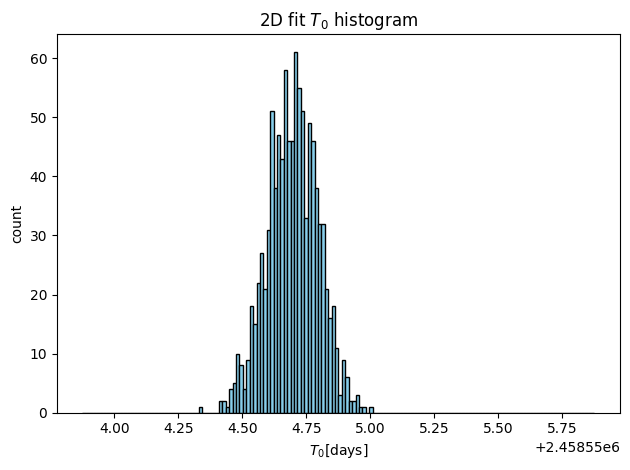

In [62]:
fig,  axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
axs.hist(T0_series,bins=150,range=[1129+min_val,1131+min_val],color='skyblue', edgecolor='black')
axs.set_title(r'2D fit $T_0$ histogram')
axs.set_ylabel('count')
axs.set_xlabel(r'$T_0$[days]')
print('T_0',T0_series.mean(),'+-', T0_series.std())
print(jnp.abs(((D2_fit[0]+min_val) - T0_series.mean())/D2_err[0]))

u_min 0.24744034066227844 +- 0.0018444613748640768
0.12025909935054521


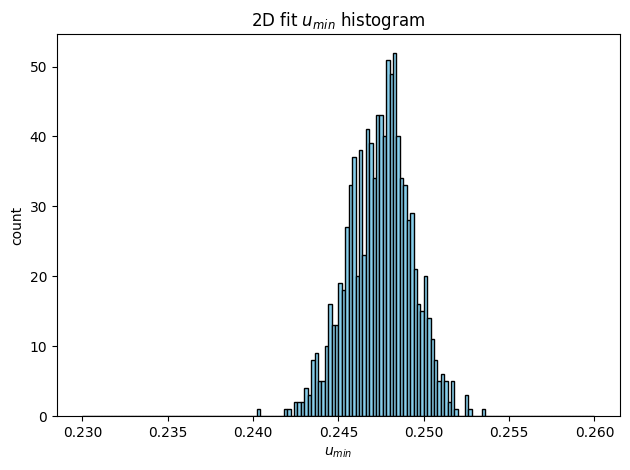

In [63]:
fig,  axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
axs.hist(u_series,bins=150,range=[0.23,0.26],color='skyblue', edgecolor='black')
axs.set_title(r'2D fit $u_{min}$ histogram')
axs.set_ylabel('count')
axs.set_xlabel(r'$u_{min}$')
print('u_min',u_series.mean(),'+-', u_series.std())
print(jnp.abs(((D2_fit[1]) - u_series.mean())/D2_err[1]))

# non-linear 4D

In [64]:

#think about better way to put constraints on f bl
@jit
def model4D(B,x):
    u = jnp.sqrt(jnp.power(B[1],2)+jnp.power((x-B[0])/B[2],2))
    mag = (jnp.power(u,2)+2)/(u*jnp.sqrt(jnp.power(u,2)+4))
    #return jnp.minimum(B[3],1.)*(mag - 1)+1
    return B[3]*(mag - 1)+1


def grad_desc_constrained(x,y,dy,model,guess, epsilon = 0.0001, learning_rate = 0.1,max_iterations = 10000,
                          constraints_max = 1.0):
    orgi_len = len(guess)
    guess = guess + [0.1,0.1,0.1,0.1]
    @partial(jit, static_argnums=(1,))
    def loss(params, model, x,y,dy):
        return chi_squared(params, model,x,y,dy) + \
    params[4]*(params[3] + jnp.power(params[5],2) - constraints_max)

    B = np.array(guess)
    # chi_grad = jit(grad(chi_squared, argnums=0), static_argnums=(1,))
    chi_grad = jit(grad(loss, argnums=0), static_argnums=(1,))
    chi_hessian = jit(hessian(loss, argnums=0), static_argnums=(1,))
    chi = loss(B,model,x,y,dy)
    chi_grad_val =chi_grad(B,model,x,y,dy)
    chi_inv_hessian_val = jnp.linalg.pinv(chi_hessian(B,model,x,y,dy))
    norm = jnp.linalg.norm(chi_grad_val)
    i = 0
    while True:
        # if norm > clip:
        #     chi_grad_val = clip * chi_grad_val/norm

        delta_B = - learning_rate * jnp.linalg.matmul(chi_inv_hessian_val, chi_grad_val)
        #print(delta_B)
        B = B  + delta_B 
        chi = loss(B,model,x,y,dy)
        chi_grad_val =chi_grad(B,model,x,y,dy)
        chi_inv_hessian_val = jnp.linalg.pinv(chi_hessian(B,model,x,y,dy))
        norm = jnp.linalg.norm(delta_B)
        if  (norm < epsilon) or (i >= max_iterations):
            hess =  chi_hessian(B,model,x,y,dy)[:orgi_len,:orgi_len]/2
            cov_matrix = jnp.linalg.pinv(hess)
            independant_errors = np.sqrt(jnp.abs(1/jnp.diag(hess)))
            dep_errors = np.sqrt(jnp.diag(cov_matrix))
            return B[:orgi_len], dep_errors, independant_errors, chi, chi/(x.shape[0] - B.shape[0]), cov_matrix
        if i % 1000 == 0:
            pass
            # print(B)
            # print(norm)
        i+=1


7220.930408889134 2.24322162438308
[1.12975154e+03 2.49954804e-01 2.90739793e+01 1.00000000e+00]
[0.06684237 0.0012616  0.22082922 0.00484357]
[0.07128971 0.01586246 1.22242355 0.0764041 ]
~~~~~~~sigma~~~~~~
T_0 2458554.6269483 +- 0.06684237114847696
u_min 0.24995480413220703 +- 0.0012615960693642058
tau 29.073979301838595 +- 0.22082921799489635
fbl 1.000000000147787 +- 0.004843569076707577
T n sigma 0.02978703545342384
u n sigma 0.5931004308338246
tau n sigma 2.60519756794622
fbl n sigma 3.051198227861885e-08


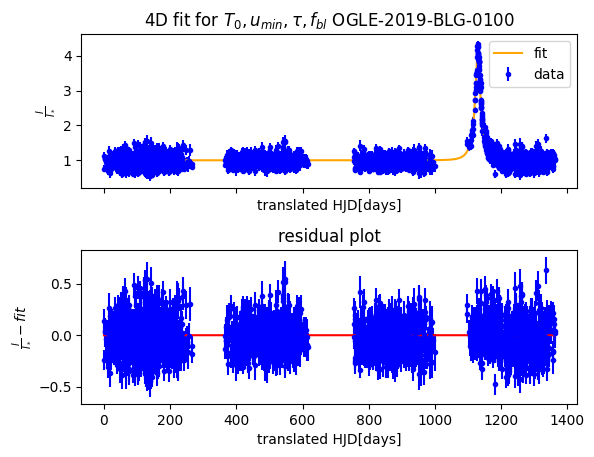

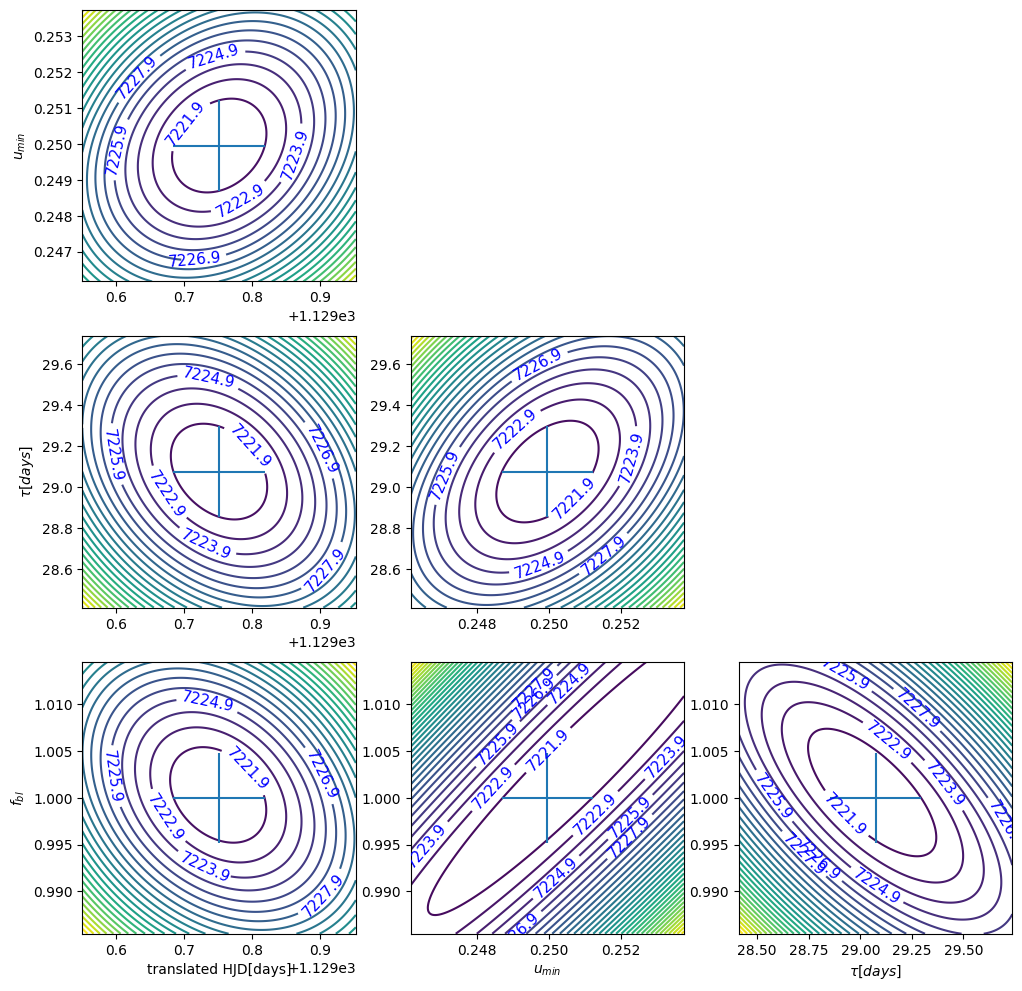

In [65]:
B,dep_errors, errors, chi, chi_red, cov = grad_desc_constrained(x,y,dy,
                                                     model=model4D,
                                                     epsilon=0.00000001,
                                                     learning_rate=0.1,
                                                     constraints_max=1.0,
                                                     guess=[par[0] - min_val,par[1], par[2], 0.7])
print(chi, chi_red)
print(B)
print(errors)
print(dep_errors)

print('~~~~~~~sigma~~~~~~')
print('T_0', B[0]+min_val,'+-', errors[0])
print('u_min', B[1],'+-', errors[1])
print('tau', B[2],'+-', errors[2])
print('fbl', B[3],'+-', errors[3])
print('T n sigma', N_sigma((B[0],errors[0]),(ogle_Tmax[0] -min_val, ogle_Tmax[1])))
print('u n sigma', N_sigma((B[1],errors[1]),ogle_umin))
print('tau n sigma', N_sigma((B[2],errors[2]),ogle_tau))
print('fbl n sigma', N_sigma((B[3],errors[3]),ogle_fbl))

plot_fit(x,y,dy,title=r'4D fit for $T_0, u_{min}, \tau, f_{bl}$ OGLE-2019-BLG-0100',model=model4D, params=B)
n = 4
label = ['translated HJD[days]', r'$u_{min}$', r'$\tau[days]$', r'$f_{bl}$']
fig = plt.figure(figsize=(12, 12))
ax1= fig.add_subplot(3,3,1)
ax2= fig.add_subplot(3,3,4)
ax3= fig.add_subplot(3,3,5)
ax4= fig.add_subplot(3,3,7)
ax5= fig.add_subplot(3,3,8)
ax6= fig.add_subplot(3,3,9)
axes = [[ax1],[ax2, ax3], [ax4, ax5, ax6]]
# plotChi2(B, errors, chi_squared, model4D,x,y,dy,i=0,j=1,xlabel='HJD[days]', ylabel=r'$f_{bi}$')
for j in range(n-1):
    for i in range(j+1):
        if j+1 == n-1:
            xlabel = label[i]
        else:
            xlabel = None

        if i == 0:
            ylabel = label[j+1]
        else:
            ylabel = None
        plotChi2(B, errors, chi_squared, model4D,x,y,dy,i=i,j=j+1,xlabel=xlabel, ylabel=ylabel, ax=axes[j][i], clabel=True,chi_spacing=1
                 )
